In [1]:
import torch
from preprocessinganddata import load_regression_data,ann_rparameters

In [2]:
train_loader , val_loader , test_loader = load_regression_data()

In [3]:
class CustomNeuralNetwork(torch.nn.Module):
    def __init__(self, layer_sizes):
        super(CustomNeuralNetwork, self).__init__()
        self.weights = torch.nn.ParameterList()
        self.biases = torch.nn.ParameterList()
        
        for i in range(len(layer_sizes) - 1):
            # Initialize weights and biases for each layer
            w = torch.nn.Parameter(torch.randn(layer_sizes[i], layer_sizes[i + 1], requires_grad=True))
            b = torch.nn.Parameter(torch.zeros(layer_sizes[i + 1], requires_grad=True))
            torch.nn.init.xavier_normal_(w)  
            self.weights.append(w)
            self.biases.append(b)
            
    def forward(self, x):
        """Forward pass through the network"""
        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            x = x.mm(w) + b
            x = torch.relu(x)
        return x
    
    def compute_loss(self, y_pred, y_true):
            """Compute Mean Squared Error Loss (for regression)"""
            return torch.nn.functional.mse_loss(y_pred, y_true) 


def train_model(model, epochs, optimizer,train_loader):
    for epoch in range(epochs):
        total_loss = 0
        for batch_idx, (x, y) in enumerate(train_loader):
            model.train()
            y_pred = model(x)

            loss = model.compute_loss(y_pred, y.view(-1, 1))

            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            total_loss += loss.item()    
    return model

In [4]:
def calculate_mse(model, data_loader):
    total_loss = 0
    total_samples = 0
    model.eval()
    with torch.no_grad():
        for x, y in data_loader:
            y_pred = model(x)
            loss = torch.nn.functional.mse_loss(y_pred, y.view(-1, 1), reduction='sum') 
            total_loss += loss.item()
            total_samples += x.size(0) 
    mse = total_loss / total_samples if total_samples > 0 else float('nan') 
    return mse


In [5]:
def train_and_evaluate(learning_rate, epochs, layer_sizes, train_loader, val_loader):
    model = CustomNeuralNetwork(layer_sizes)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    model = train_model(model, epochs=epochs, optimizer=optimizer, train_loader=train_loader)
    
    val_mse = calculate_mse(model, val_loader)
    return model , val_mse


# Perform the grid search
def grid_search(grid_combinations , train_loader, val_loader):
    best_config = None
    best_mse = float('inf')  # Start with an infinitely large error
    best_model = None
    # Iterate over all combinations in the grid
    for lr, ep, layers in grid_combinations:
        
        # Train and evaluate for the current configuration
        model , mse = train_and_evaluate(lr, ep, layers, train_loader, val_loader)
        print(f"Testing configuration: LR={lr}, Epochs={ep}, Layers={layers}, Validation MSE: {mse:.4f}")
        
        # Update best config if current mse is better
        if mse < best_mse:
            best_mse = mse
            best_config = {'learning_rate': lr, 'epochs': ep, 'layer_sizes': layers}
            best_model = model
    # Output the best configuration found
    print("\nBest Configuration:")
    print(f"Learning Rate: {best_config['learning_rate']}")
    print(f"Epochs: {best_config['epochs']}")
    print(f"Layer Sizes: {best_config['layer_sizes']}")
    print(f"Validation MSE: {best_mse:.4f}")
    
    return best_model , best_config, best_mse

# Call the grid search method

In [15]:
# grid_combinations = ann_rparameters()
# best_model , best_config, best_mse = grid_search(grid_combinations , train_loader, val_loader)

Testing configuration: LR=0.001, Epochs=10, Layers=[8, 50, 1], Validation MSE: 0.9657
Testing configuration: LR=0.001, Epochs=10, Layers=[8, 80, 50, 1], Validation MSE: 0.8308
Testing configuration: LR=0.001, Epochs=10, Layers=[8, 80, 50, 35, 1], Validation MSE: 5.7567
Testing configuration: LR=0.001, Epochs=20, Layers=[8, 50, 1], Validation MSE: 0.7206
Testing configuration: LR=0.001, Epochs=20, Layers=[8, 80, 50, 1], Validation MSE: 0.6310
Testing configuration: LR=0.001, Epochs=20, Layers=[8, 80, 50, 35, 1], Validation MSE: 0.6211
Testing configuration: LR=0.01, Epochs=10, Layers=[8, 50, 1], Validation MSE: 0.5413
Testing configuration: LR=0.01, Epochs=10, Layers=[8, 80, 50, 1], Validation MSE: 0.4897
Testing configuration: LR=0.01, Epochs=10, Layers=[8, 80, 50, 35, 1], Validation MSE: 0.4430
Testing configuration: LR=0.01, Epochs=20, Layers=[8, 50, 1], Validation MSE: 0.4599
Testing configuration: LR=0.01, Epochs=20, Layers=[8, 80, 50, 1], Validation MSE: 0.4220
Testing configurati

In [6]:
model = CustomNeuralNetwork([8 , 80 , 50 , 1])
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
model = train_model(model, epochs=1000, optimizer=optimizer, train_loader=train_loader)

In [7]:
# Calculate training and test MSE
train_mse = calculate_mse(model , train_loader)
test_mse = calculate_mse(model, test_loader)

print(f'Training MSE: {train_mse:.2f}')
print(f'Test MSE: {test_mse:.2f}')

Training MSE: 0.16
Test MSE: 0.30


In [8]:
# Save the trained model's state_dict
torch.save(model.state_dict(), "regression_model")

In [9]:
# Load the model's state_dict for evaluation
loaded_model = CustomNeuralNetwork([8 , 80 , 50 , 1])
model.load_state_dict(torch.load("regression_model"))
model.eval()
print("Model Loaded")

Model Loaded


C:\Users\user\AppData\Local\Temp\ipykernel_5292\3886151947.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("regression_model"))


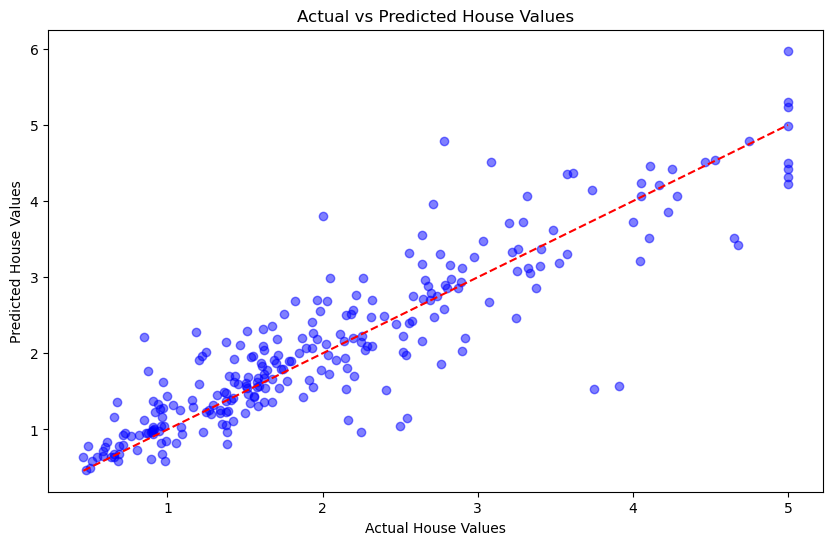

In [10]:
import matplotlib.pyplot as plt

# Get a batch from the test loader
data_iter = iter(test_loader)
inputs, actual_values = next(data_iter)

# Predict
outputs = model(inputs)

# Convert to numpy for easier handling in matplotlib
actual_values = actual_values.numpy()
predicted_values = outputs.detach().numpy().flatten()

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual_values, predicted_values, color='blue', alpha=0.5)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], color='red', linestyle='--')
plt.xlabel('Actual House Values')
plt.ylabel('Predicted House Values')
plt.title('Actual vs Predicted House Values')
plt.show()
